# Photometry with XGA

This tutorial will show you how to generate photometric products (ie. images, exposure maps, and ratemaps) from XGA sources, and cover the basics of interacting with the XGA photometric products, including using source masks and the built in peak finding techniques.

In order to generate these products, XGA must interact with telescope-specific software, such as SAS for XMM and eSASS for eROSITA, therefore the user must have the appropriate software installed to interact with certain data. XGA will check for the presence of the relevant software before trying to run any routines that depend on it. 

This demonstration will detail the XGA features that are common to every supported telescope. However, please note that products made from different telescopes will have certain telescope-specific quirks associated with them, that arise from interaction with their corresponding software - e.g. the way XMM's SAS generates images is different to the way eROSITA's eSASS does. Consequently, there will be some differing optional arguments available within XGA's built in functions that interact with these softwares. **It is therefore important to read [the multi mission tutorial](multimission.ipynb), where caveats associated with interacting with telescope-specific software are detailed, along with reccomendations, and useful tips when considering data from certain telescopes.** 

In [1]:
from astropy.units import Quantity
from astropy.visualization import LinearStretch
import numpy as np
import pandas as pd

from xga.sources import GalaxyCluster, NullSource
from xga.samples import ClusterSample
from xga.generate.sas import evselect_image, eexpmap, emosaic
from xga.generate.esass import evtool_image, expmap
from xga.utils import xmm_sky

/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/utils.py:39: DeprecationWarning: The XGA 'find_all_wcs' function should be imported from imagetools.misc, in the future it will be removed from utils.
  warn(message, DeprecationWarning)
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/_geometry/__init__.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .polygonal_overlap import *


First we declare both an individual galaxy cluster source object, and a galaxy cluster sample object; in order to show that the generation of products from individual sources and samples of sources is done in the same way. The sample of four clusters is taken from the DES-Y1 sample (Farahi et al. 2019), and the individual cluster is Abell 907. 

In [2]:
# Setting up the column names and numpy array that go into the Pandas dataframe
column_names = ['name', 'ra', 'dec', 'z', 'r500', 'richness', 'richness_err']
cluster_data = np.array([['DEMO-1', 40.912, -48.561, 0.495, 2.539, 138.504, 4.243],
                         ['DEMO-2', 41.353, -53.029, 0.300, 4.720, 150.571, 4.141],
                         ['DEMO-3', 43.565, -58.953, 0.428, 3.292, 221.674, 5.713],
                         ['DEMO-4', 79.156, -54.500, 0.273, 1157.04, 1684.15, 108.60]])

sample_df = pd.DataFrame(data=cluster_data, columns=column_names)
sample_df[['ra', 'dec', 'z', 'r500', 'richness', 'richness_err']] = \
    sample_df[['ra', 'dec', 'z', 'r500', 'richness', 'richness_err']].astype(float)

# Defining the sample of four DES galaxy clusters
demo_smp = ClusterSample(sample_df["ra"].values, sample_df["dec"].values, sample_df["z"].values, 
                         sample_df["name"].values,
                         r500=Quantity(sample_df["r500"].values, 'arcmin'), 
                         richness=sample_df['richness'].values, 
                         richness_err=sample_df['richness_err'].values,
                         search_distance={'erosita': Quantity(2, 'deg')})

# And defining an individual source object for Abell 907
demo_src = GalaxyCluster(149.59209, -11.05972, 0.16, r500=Quantity(1200, 'kpc'), r200=Quantity(1700, 'kpc'), 
                         name="A907", search_distance={'erosita': Quantity(3, 'deg'), 
                                     'xmm': Quantity(30, 'arcmin')})

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Declaring BaseSource Sample:   0%|          | 0/4 [00:00<?, ?it/s]/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/sources/base.py:188: UserWarning: A dictionary of search distances that did not contain all requested telescopes has been passed, default values have been used for the missing telescopes.
  matches, excluded = separation_match(ra, dec, search_distance, telescope)
Declaring BaseSource Sample:  25%|██▌       | 1/4 [00:00<00:00,  6.36it/s]/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/sources/base.py:188: UserWarning: A dictionary of search distances that did not contain all requested t

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = self.operator(*np.array(padded_data, dtype=np.int))
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify th

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = self.operator(*np.array(padded_data, dtype=np.int))
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify th

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = self.operator(*np.array(padded_data, dtype=np.int))
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify th

In [3]:
demo_smp.info()


-----------------------------------------------------
Number of Sources - 4
Redshift Information - True
Sources with ≥1 detection - 4 [100%]
-----------------------------------------------------



/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Please also note that ClusterSample class automatically generates images and exposure maps in the energy range used for peak finding (set by the keyword arguments `peak_lo_en` and `peak_hi_en`, by default 0.5keV and 2.0keV respectively). An individual GalaxyCluster source object will also automatically generate images and exposure maps in this range, but only if the `use_peak` keyword argument is set to True (which it is by default).

## Generating Images with XGA

When specifying the energy range to generate in, we use Astropy quantities in units of keV - though you could supply limits in any energy unit:

In [4]:
# Setting up the lower and upper energy bounds for our products
lo_en = Quantity(0.5, 'keV')
hi_en = Quantity(10.0, 'keV')

To generate images from any **XMM** observations associated with the Sample and Source, the `evselect_image` function is used. 

In [5]:
# This will generate images in the 0.5-10keV range,
#  for every instrument in every XMM ObsID in every source in this sample
demo_smp = evselect_image(demo_smp, lo_en=lo_en, hi_en=hi_en)

# The function call is identical when generating images for an individual source, but here 
#  we limit XGA to using only four cores
demo_src = evselect_image(demo_src, lo_en=lo_en, hi_en=hi_en, num_cores=4)

Generating products of type(s) image: 100%|██████████| 9/9 [00:01<00:00,  7.68it/s]


To generate images from any **eROSITA** observations associated with the Sample and Source, the `evtool_image` function is used. 

In [6]:
# This will generate images in the 0.5-10keV range. 
# For every eROSITA observation, one image is made from a combination of all telescope modules
# This is done for every source in this sample
demo_smp = evtool_image(demo_smp, lo_en=lo_en, hi_en=hi_en)

# The function call is identical when generating images for an individual source, but here 
#  we limit XGA to using only four cores
demo_src = evtool_image(demo_src, lo_en=lo_en, hi_en=hi_en, num_cores=4)

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Generating products of type(s) image: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


These images have now been generated and associated with the appropriate source.

## Generating Exposure Maps with XGA

The process for generating exposure maps is almost identical to the image generation process, we simply call a different function.

For **XMM** exposure maps the `eexpmap` function is used. 

In [7]:
# This will generate expmaps in the 0.5-10keV range, 
# for every instrument in every XMM ObsID in every source in this sample
demo_smp = eexpmap(demo_smp, lo_en=lo_en, hi_en=hi_en)

# The function call is identical when generating expmaps for an individual source
demo_src = eexpmap(demo_src, lo_en=lo_en, hi_en=hi_en)

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Generating products of type(s) expmap: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


For **eROSITA** exposure maps the `expmap` function is used. 

Note that eROSITA exposure maps can take some time to generate (see [the multi mission tutorial](multimission.ipynb) for more details).

In [8]:
# This will generate exposure in the 0.5-10keV range. 
# For every eROSITA observation, one image is made from a combination of all telescope modules
# This is done for every source in this sample
demo_smp = expmap(demo_smp, lo_en=lo_en, hi_en=hi_en)

# The function call is identical when generating expmaps for an individual source
demo_src = expmap(demo_src, lo_en=lo_en, hi_en=hi_en)

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Generating products of type(s) expmap: 100%|██████████| 3/3 [05:41<00:00, 113.70s/it]


In [17]:
demo_src.obs_ids

{'xmm': ['0404910601', '0201901401', '0201903501'],
 'erosita': ['148102', '151102', '150099']}

## XGA Ratemaps

Now that we've generated images and exposure maps for our custom energy range, we can see that XGA has automatically made RateMaps from those products.

The individual source is used as a demonstration here. There are twelve ratemaps present because there are three XMM observations of Abell 907, each with three valid instruments, and 3 eROSITA observations, each with one ratemap made for the combination of all eROSITA instruments:

In [21]:
rts = demo_src.get_ratemaps(lo_en=lo_en, hi_en=hi_en)
rts

## Basic properties of ANY XGA Product

Here some of the most basic (but still useful) properties of XGA's photometric products are demonstrated. We use one of the ratemaps generated for Abell 907, but the properties demonstrated in this section will be present in **any** XGA photometric product. These first properties should actually be present in every XGA product, photometric or otherwise:

In [18]:
chosen_ratemap = rts[0] 

# If generated using XGA, the product stores the name 
#  of the source it is associated with
print(chosen_ratemap.src_name, '\n')

# Its also aware of what ObsID and instrument it is from
print(chosen_ratemap.obs_id, chosen_ratemap.instrument, '\n')

# And where the base file is stored 
print(chosen_ratemap.path)

A907 

0404910601 pn 

/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/docs/source/notebooks/tutorials/xga_output/xmm/0404910601/0404910601_pn_0.5-10.0keVimg.fits


## Basic properties of XGA Photometric products

Here it is demonstrated how to access the data and fits header information of an XGA photometric product. We showcase some of the useful functions that are built into photometric objects.

Accessing an image's (or in this case a ratemap's) data is extremely simple, with the added benefit that data is not loaded into memory from the disk until the user actually wants to access it. Its possible to have hundreds of images associated with a single source, so avoiding having data in memory unless its needed helps stop us running out of RAM.

You shouldn't be concerned that the data shown here is are all zeros, the outskirts of the ratemap are off of the XMM detector and as such have a countrate of zero:

In [19]:
# Retrieving the data as a numpy array is as simple as 
#  calling the data property
my_ratemap_data = chosen_ratemap.data
my_ratemap_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

You can also retrieve the whole header of the fits image by using the header property:

In [22]:
chosen_ratemap.header


SIMPLE  =                    T / file does conform to FITS standard
BITPIX  =                   32 / number of bits per data pixel
NAXIS   =                    2 / number of data axes
NAXIS1  =                  512 / length of data axis 1
NAXIS2  =                  512 / length of data axis 2
EXTEND  =                    T / FITS dataset may contain extensions
XPROC0  = 'evselect table=/mnt/lustre/projects/astro/general/xcs/XMM_observatio'
XDAL0   = '0404910601_pn_0.5-10.0keVimg.fits 2024-03-20T16:47:22.000 Create evs'
CREATOR = 'evselect (evselect-3.68) [xmmsas_20190531_1155-18.0.0]' / name of cod
DATE    = '2024-03-20T16:47:22.000' / creation date
ORIGIN  = 'User site'          / 
ODSVER  = '16.911'             / ODS version
ODSCHAIN= 'S2KO'               / Processing Chain
FILTER  = 'Thin1'              / Filter ID
FRMTIME =                  199 / [ms] Frame Time, nearest integer
TELESCOP= 'XMM'                / Telescope (mission) name
INSTRUME= 'EPN'                / Instrument n

And a specific entry by indexing the header object using the entries name:

In [23]:
chosen_ratemap.header['OBSERVER']

'Prof Hans Boehringer'

## Converting coordinates with XGA Photometric products

Reading in the header means that XGA has access to the World Coordinate System ([WCS](https://fits.gsfc.nasa.gov/fits_wcs.html)) information of the fits image, and using this XGA's inbuilt function `coord_conv()` can convert between different coordinate systems for a given photometric product. Again, any coordinates must be passed in as Astropy quantity objects:

In [24]:
# Defining a position to convert in pixel coordinates
pix_coord = Quantity([100, 100], 'pix')

# The pixel coordinate can be converted to degrees like this
print(chosen_ratemap.coord_conv(pix_coord, 'deg'), '\n')

# If the product fits file had a WCS entry for the XMM sky coordinates system,
#  then we can convert to that as well
print(chosen_ratemap.coord_conv(pix_coord, 'xmm_sky'))

[149.782975   -11.27656289] deg 

[12392. 12392.] xmm_sky


We can also actually define an Astropy quantity in XMM's sky units, by dint of a custom unit defined in the XGA *utils* file (this is imported at the top of this tutorial). Please be aware that the Astropy module is not aware of this custom unit, so defining a quantity with a string representation of the unit will not work:

In [25]:
# Defining an XMM Sky position
sky_coord = Quantity([15000, 15000], xmm_sky)

# Converting to pixels
print(chosen_ratemap.coord_conv(sky_coord, 'pix'), '\n')

# Converting to an RA-Dec position
print(chosen_ratemap.coord_conv(sky_coord, 'deg'))

[130 130] pix 

[149.74602109 -11.24036252] deg


We can also easily convert between any combination of these units, and here it is demonstrated how to convert the user supplied coordinates (used when the cluster was defined), as well as the peak coordinates found during declaration:

In [27]:
# This is an easy way to access the coordinates the user passed in when declaring the source
print('The initial coordinates were', demo_src.ra_dec)
print(chosen_ratemap.coord_conv(demo_src.ra_dec, 'pix'), '\n')

# And an equally easy way to access the peak coordinates
print('The peak coordinates are', demo_src.peak)
print(chosen_ratemap.coord_conv(demo_src.peak, 'pix'), '\n')

The initial coordinates were [149.59209 -11.05972] deg
[255 280] pix 

The peak coordinates are [149.59251341 -11.06395832] deg
[255 276] pix 



<ipython-input-27-eee689d47c22>:6: UserWarning: Multiple telescopes are associated with source A907 - we do not yet support combining peak information, so the XMM peak is being returned.
  print('The peak coordinates are', demo_src.peak)
<ipython-input-27-eee689d47c22>:7: UserWarning: Multiple telescopes are associated with source A907 - we do not yet support combining peak information, so the XMM peak is being returned.
  print(chosen_ratemap.coord_conv(demo_src.peak, 'pix'), '\n')


## Viewing XGA Photometric products

One of the most useful features built into XGA's photometric products is the ability to easily visualise them with the `view()` method. There are multiple ways to modify the image produced, this includes changing the size of the image, altering the scaling applied (log-scaling is used by default), applying masks, zooming in specific parts of the image, and adding crosshairs to indicate a coordinate.

Again, we're using a ratemap taken from Abell 907, and with one simple line of code we can produce a useful visualisation. Here the size of the image is increased so that it looks better in the documentation, and used the crosshairs to highlight the coordinate of the user supplied position. Only one crosshair can be placed on an image, but the coordinate can be in degrees, or pixels (or XMM sky coordinates for XMM images):

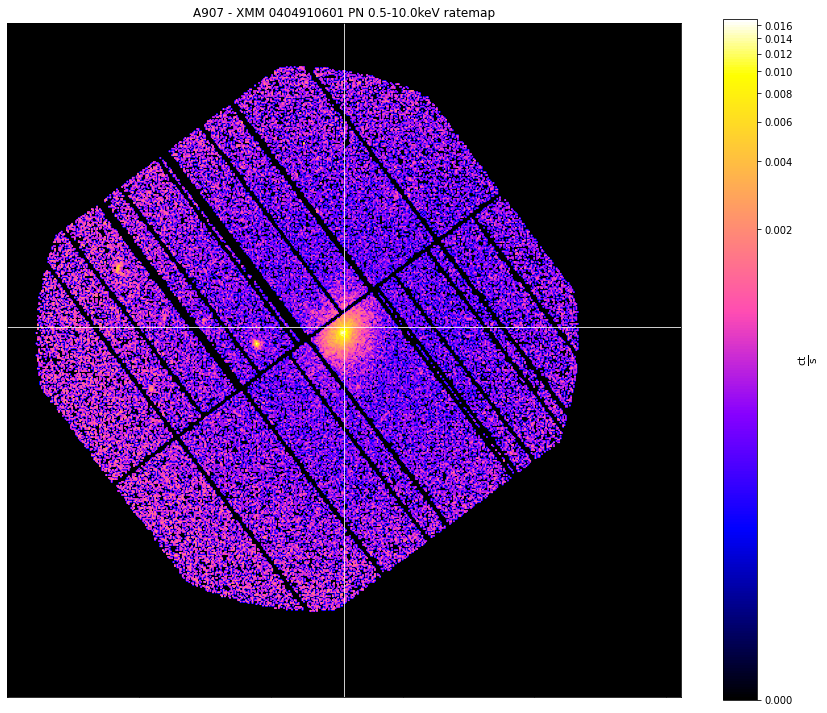

In [28]:
# Displaying the ratemap, with a crosshair for a particular coordinate
chosen_ratemap.view(cross_hair=demo_src.ra_dec, figsize=(12, 10))

## Retrieving a value at a certain coordinate

At some point you may wish to know the value of a photometric product at a certain coordinate, a ratemap or an exposure map for instance. There are built in methods to help you retrieve those values which will accept coordinates in any valid unit (degrees, pixels, or XMM sky for XMM products). The value is returned as an Astropy quantity, with the correct units for the type of product.

We demonstrate a useful feature of ratemap, that it stores links to the image and expmap that were used to create it, so accessing those constituent products is as easy as using the 'image' or 'expmap' properties of the ratemap:

In [29]:
# For a ratemap, we use the method 'get_rate'
print(chosen_ratemap.get_rate(demo_src.ra_dec), '\n')

# If we wished to know the exposure time at that position, we could access the ratemap's 
#  expmap and use 'get_exp'
print(chosen_ratemap.expmap.get_exp(demo_src.ra_dec), '\n')

0.0062226445925877135 ct / s 

4981.8046875 s 



## Combined images and exposure maps

For XMM observations of a source, it is possible to combine each photometric product (ie. for each instrument for each observation). This is fully detailed in [the multi mission tutorial](multimission.ipynb).

## Retrieving and using masks from a source

It is common practise in photometric analyses to mask out any sources that might bias or interfere with the source that you are investigating, and as such each XGA source object is able to produce masking arrays. These masking arrays are filled with ones and zeros, where any zero elements are to be considered 'masked', and masked image/expmap/ratemap data can be calculated by multiplying the image/expmap/ratemap data by the masking array.

XGA is capable of producing several types of mask; interloper masks (where non-relevant sources are masked), source masks (where any part of the product not within a certain source region is masked out), and standard masks (which are a combination of the last two types).

An XGA source can generate masks for any of the ObsIDs associated with it. 

This will be demonstrated on an XMM ratemap that is a combination of all observations of this source for every instrument (for more details on combined products see [the multi mission tutorial](multimission.ipynb)). Firstly, let's generate it:

In [39]:
# To get a combined ratemap, the combined images and exposure maps must first be made
demo_src = emosaic(demo_src, 'image', lo_en=lo_en, hi_en=hi_en)
demo_src = emosaic(demo_src, 'expmap', lo_en=lo_en, hi_en=hi_en)


chosen_comb_rt = demo_src.get_combined_ratemaps(lo_en=lo_en, hi_en=hi_en)

Now we make a mask that will remove non-relevant sources, a telescope must be specified when generating a mask:

Note that for XMM observations, if no ObsID information is supplied then XGA will assume that the mask should be generated for a combined photometric product.

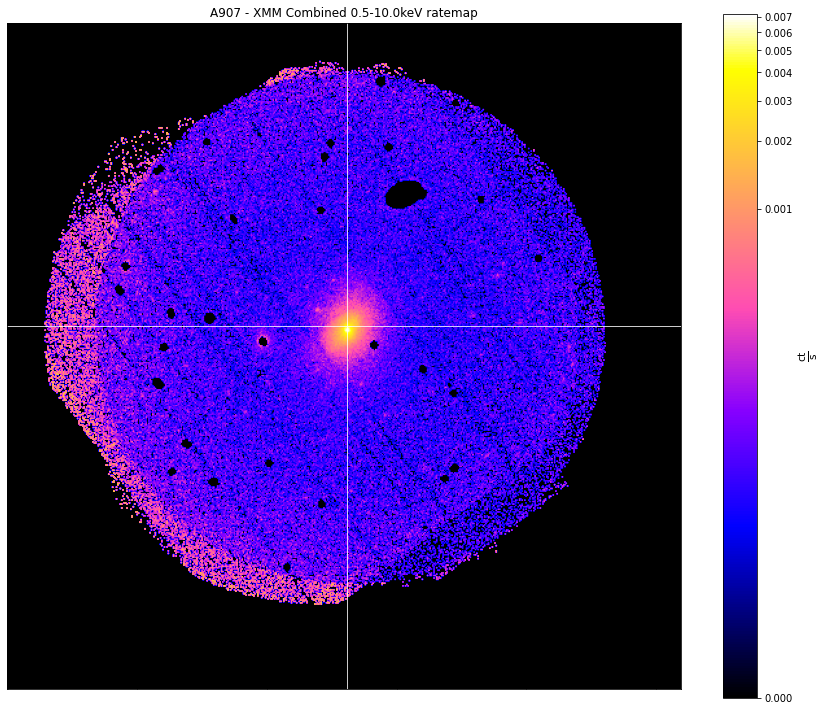

In [40]:
# This generates a mask that removes interloper sources (any non-relevant source). As we
#  didn't provide an ObsID it is only valid for the combined products
interloper_mask = demo_src.get_interloper_mask('xmm')


# It is very easy to apply the mask to remove any interlopers from the ratemap
chosen_comb_rt.view(cross_hair=demo_src.ra_dec, mask=interloper_mask, figsize=(12, 10))

Its just as easy to produce an interloper mask for a specific ObsID, and though the ratemaps look extremely similar, please note that this is because the three XMM observations associated with this source all have near identical pointing coordinates. That means that the shape of this image is *very* similar to the 512x512 of the individual images. This may not be the case for other sources, where separate observations added together can result in quite different image shapes.

Here we produce a mask for the Abell 907 ratemap we retrieved earlier:

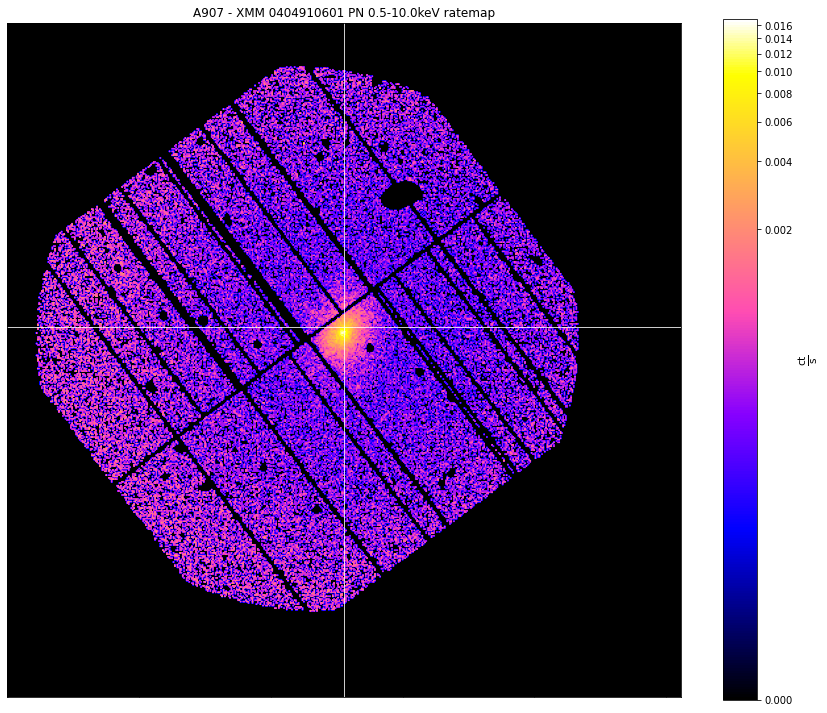

In [42]:
# Much the same process as to generate the mask for the combined ratemap, but we also supply an ObsID
individual_interloper_mask = demo_src.get_interloper_mask(obs_id=chosen_ratemap.obs_id, telescope='xmm')

# It is very easy to apply the mask to remove any interlopers from the ratemap
chosen_ratemap.view(cross_hair=demo_src.ra_dec, mask=individual_interloper_mask, figsize=(12, 10))

Now we are going to learn how to generate masks that lets us select the source region of interest. At this point we have to make a choice as to which source region we're interested in; most source objects will allow us to generate a mask from the region files which were supplied to XGA in the configuration file, but if you have a point source then you could also choose 'point', and if you have a Galaxy Cluster then you could also select one of the overdensity regions (such as 'r200').

When you generate a source region mask, you will also be supplied with a matching background region mask, which is a region extending between `back_inn_rad_factor` - `back_out_rad_factor` multiplied by the radius of interest, where these keyword arguments are set when defining a source object.

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/lustre/projects/astro/general/jp735/XGA_dev/XGA/xga/sources/base.py:3550: UserWarning: You cannot use custom central coordinates with a region from supplied region files
  src_reg, bck_reg = self.source_back_regions(reg_type, telescope, obs_id, central_coord)
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the 

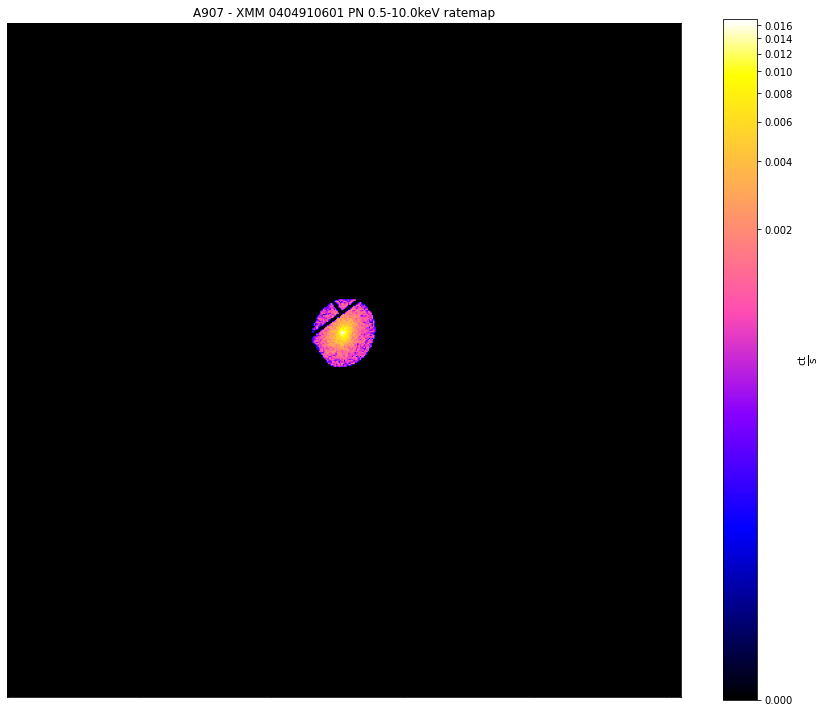

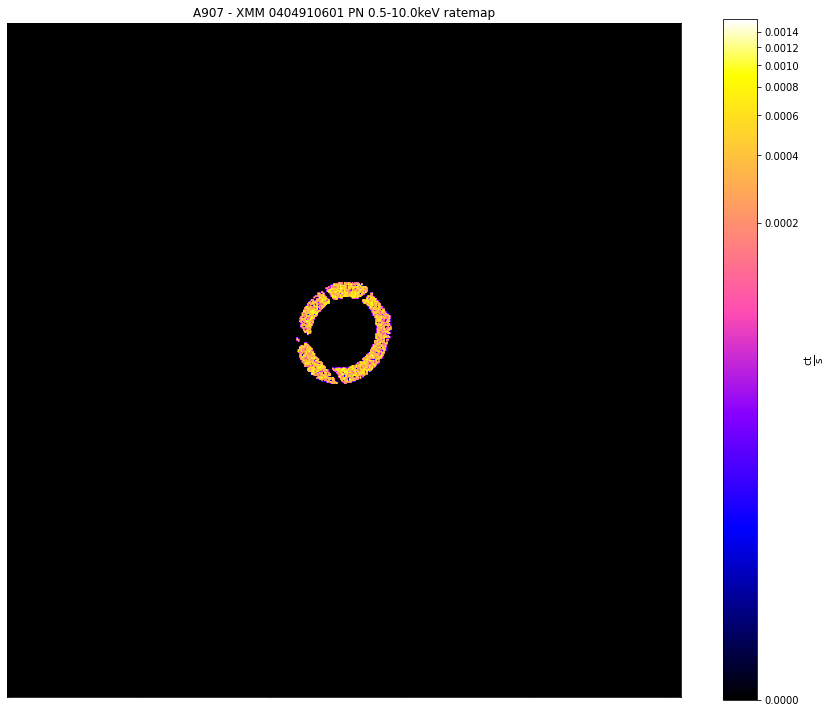

In [45]:
# A source and background mask generated for the selected source from our region file for
#  this particular ObsID
region_masks = demo_src.get_source_mask('region', 'xmm', obs_id=chosen_ratemap.obs_id)

# The source mask applied to the 0404910601-PN ratemap in the 0.5-10.0keV range
chosen_ratemap.view(mask=region_masks[0], figsize=(12, 10))
# The show the background mask applied to this ratemap
chosen_ratemap.view(mask=region_masks[1], figsize=(12, 10))

Now we've seen how to access a region file region, we're going to look at an R$_{500}$ region. We set `zoom_in=True` which crops around the area with a non-zero value:

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = self.operator(*np.array(pad

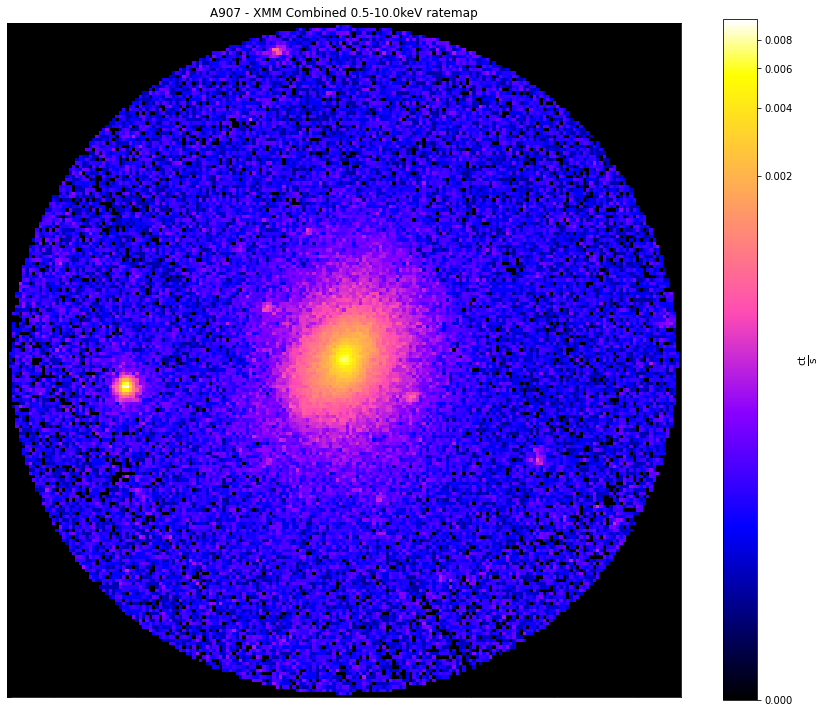

In [48]:
# A source and background mask generated for the combined ratemap for Abell 907 at R_500
# Note that a telescope must always be parsed to any get_mask method
r500_masks = demo_src.get_source_mask('r500', 'xmm')

# Here I will show the source mask applied to the combined ratemap in the 0.5-10.0keV range
chosen_comb_rt.view(mask=r500_masks[0], figsize=(12, 10), zoom_in=True)

Finally, we can still see that there are some obvious point sources remaining in this source region, and for a real analysis we would want to be able to remove them. As such we use the source method 'get_mask', and apply it to the same combined ratemap.

It is important to note that the user does not have to generate these masks centered at the default central coordinates for the source object in question, you can also specify another central coordinate using **central_coord** in a mask generation method.

When we see the image below we can quite clearly see examples of a few point sources that obviously have to be removed before a meaningful analysis of the galaxy cluster can begin:

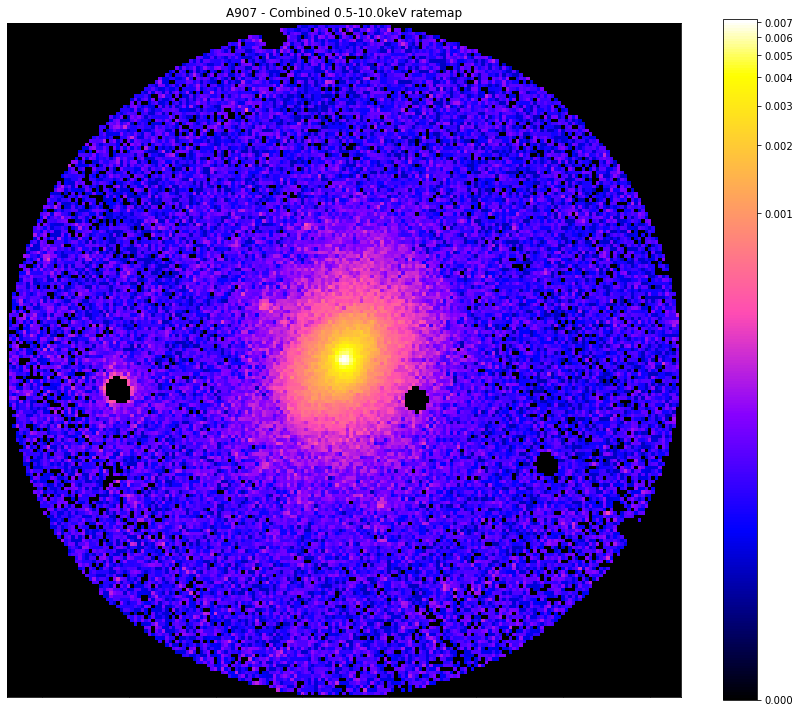

In [23]:
# A source and background mask generated for the combined ratemap for Abell 907 at R_500
r500_interloper_masks = demo_src.get_mask('r500',)

# Here I will show the source mask applied to the combined ratemap in the 0.5-10.0keV range
chosen_comb_rt.view(mask=r500_interloper_masks[0], figsize=(12, 10), zoom_in=True)

## Creating a custom mask

A mask may be created with whatever custom radius you desire, custom coordinates to centre the new mask on may be defined, as well as both inner and outer radii (if you wish to make an annulus). In this demonstration a mask with an outer radius of 0.01 degrees is made (though if the source in question has redshift information you can also use a proper distance unit) for the XMM combined image of the demo source:

In [50]:
custom_mask = demo_src.get_custom_mask(Quantity(0.01, 'deg'), 'xmm')
custom_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

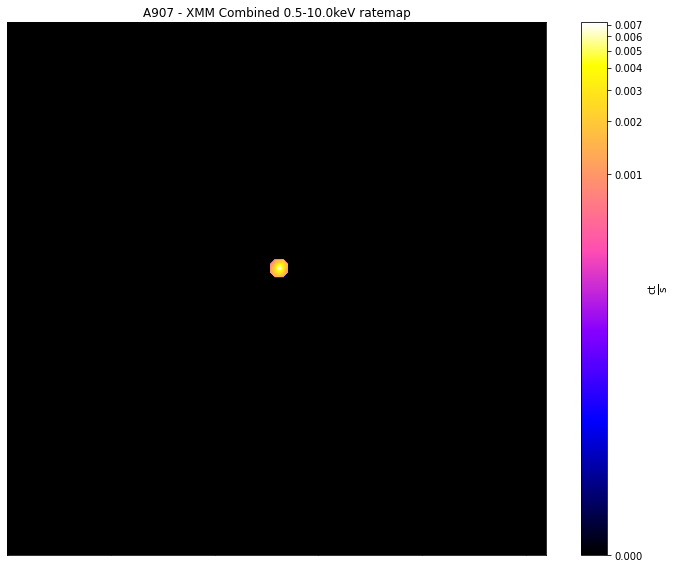

In [53]:
chosen_comb_rt.view(mask=custom_mask)

Now we make a mask with the core of this galaxy cluster excised (the mask shall allow everything from 0.15-1R$_{500}$), here we set `remove_interloper=False`, so non-relevant sources remain in the image:

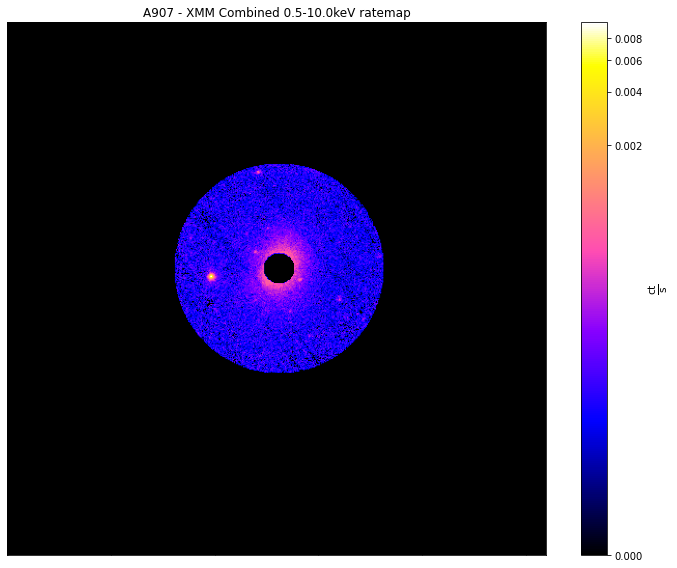

In [56]:
custom_mask = demo_src.get_custom_mask(demo_src.r500, 'xmm', 
                                       inner_rad=demo_src.r500*0.15, 
                                       remove_interlopers=False)
chosen_comb_rt.view(mask=custom_mask)

## Measuring signal-to-noise

Measuring the signal to noise of a given source is a fairly common task in astronomy, and an ability which has been implemented and added to the photometric product classes in XGA. It is a simple matter to quickly find the signal to noise of a galaxy cluster within an overdensity radius for instance, you need only call the `info()` method. There you will find that XGA has automatically measured the signal-to-noise within the supplied overdensity radii:

In [57]:
demo_src.info()


-----------------------------------------------------
Source Name - A907
User Coordinates - (149.59209, -11.05972) degrees


KeyError: 'combined'

If, however, you wish to retrieve the signal to noise programmatically (or measure it within a custom radius), you can simply use the `get_snr` method. In this demonstration we retrieve the signal to noise of this cluster within the R$_{500}$ and within a custom radius of 300kpc:

Note that you must parse a telescope argument

In [60]:
r500_snr = demo_src.get_snr('r500', 'xmm')
print(r500_snr)
cust_snr = demo_src.get_snr(Quantity(300, 'kpc'), 'xmm')
print(cust_snr)

251.27067538813375
209.05353673494383


/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/regions/core/compound.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = self.operator(*np.array(pad

A simple assessment may be performed determining which observation associated with a given source is 'the best', by ranking them by signal to noise of the source. Call the `snr_ranking` method, supply it with a radius within which to measure the SNR, and it will return an array of ObsID-instrument combinations, and an array of SNR values, going from worst to best:

In [63]:
oi_combs, snr_vals = demo_src.snr_ranking('r500')

NotAssociatedError: xmm is not associated with the xmm telescope for A907. 

In [64]:
oi_combs

NameError: name 'oi_combs' is not defined

In [66]:
snr_vals

NameError: name 'snr_vals' is not defined

## Bulk generation of photometric products

If you wished to generate images in a particular energy range for a large number of unrelated observations, then you would use a NullSource object.

Normally, when defining a NullSource object, it would automatically associate every available ObsID with itself, but it is possible to pass a list of specific ObsIDs of interest (as done in this demo). These ObsIDs must be parsed as dictionary with telescope top-level keys, if a telescope is not included in this dictionary then every observation will be associated to the NullSource, so here we pass an empty list for eROSITA:

In [70]:
# Four randomly select observation that will make up the NullSource
chosen_obs = ['0677630133', '0301900401', '0770581201', '0827201501']
# And defining the source with four unrelated observations associated with it
# This should be parsed as a dictionary with telescope top level keys
bulk_src = NullSource({'xmm': chosen_obs, 'erosita': []})

In [71]:
# If we run the standard info() method then we can say a very little information about the source
bulk_src.info()


-----------------------------------------------------
Source Name - AllObservations
User Coordinates - (nan, nan) degrees
nH - nan 1e+22 / cm2

-- XMM --
ObsIDs - 4
PN Observations - 4
MOS1 Observations - 4
MOS2 Observations - 4
With initial detection - 0
Spectra associated - 0
-----------------------------------------------------



/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we can generate images for this bulk sample:

In [73]:
# And of course we can generate images and exposure maps in the same way as with the other sources
evselect_image(bulk_src, lo_en=lo_en, hi_en=hi_en)

/its/home/jp735/.conda/envs/xga_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
